## Problem Statement

__Predict customer happiness to improve service quality.__


ACME is one of the fastest growing startups in the logistics and delivery domain. They work with several partners and make on-demand delivery to the customers. During the COVID-19 pandemic, they are facing several different challenges and trying to address these challenges by measuring the happiness of each customer based on their feedback.

__Goal(s)__: The goal of this project is to predict if the customer is happy or not based on their feedback.

__Success Metrics__: Reach 73% accuracy score or above or convince why your solution is superior.Provide your insight in finding which questions/features are more important when predicting a customer’s happiness. Using a feature selection approach show us understand what is the minimal set of attributes/features that would preserve the most information about the problem while increasing predictability of the data we have. Is there any question that we can remove in our next survey?

### Data Description:

Y = target attribute (Y) with values indicating 0 (unhappy) and 1 (happy) customers

X1 = my order was delivered on time

X2 = contents of my order was as I expected

X3 = I ordered everything I wanted to order

X4 = I paid a good price for my order

X5 = I am satisfied with my courier

X6 = the app makes ordering easy for me

Attributes X1 to X6 indicate the responses for each question and have values from 1 to 5 where the smaller number indicates less and the higher number indicates more towards the answer.


### Download Data
[Here](https://drive.google.com/file/d/1KWE3J0uU_sFIJnZ74Id3FDBcejELI7FD/view)

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import scikit-learn tools, grid search cross validation, and classifiers

from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split, cross_val_score,RandomizedSearchCV,GridSearchCV
# import Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# import Logistic Regression CV Classifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, roc_auc_score

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# import lazy predict
import lazypredict

from lazypredict.Supervised import LazyClassifier

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [42]:
#import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from scipy.stats import randint, uniform
import scipy.stats as stats
from sklearn.utils.fixes import loguniform

# import Recursive Feature Elimination (RFE)
from sklearn.feature_selection import RFE

# import stacking classifier
from sklearn.ensemble import StackingClassifier

from sklearn.neighbors import KNeighborsClassifier

In [4]:
# load the dataset
customer_data = pd.read_csv('ACME-HappinessSurvey2020.csv')
customer_data.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [5]:
# no of rows and columns in the dataset
customer_data.shape

(126, 7)

In [6]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


In [7]:
# rename the columns
customer_data = customer_data.rename(columns = {'Y': 'happiness', 'X1':'on_time_delivery', 'X2':'contents_of_order', 'X3':'ordered_everything', 'X4': 'good_price_paid', 'X5':'courier_satisfaction', 'X6': 'easy_ordering_app'})
customer_data.head()

,happiness,on_time_delivery,contents_of_order,ordered_everything,good_price_paid,courier_satisfaction,easy_ordering_app
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [8]:
customer_data.describe()

,happiness,on_time_delivery,contents_of_order,ordered_everything,good_price_paid,courier_satisfaction,easy_ordering_app
count,126.00,126.00,126.00,126.00,126.00,126.00,126.00
mean,0.55,4.33,2.53,3.31,3.75,3.65,4.25
std,0.50,0.80,1.11,1.02,0.88,1.15,0.81
min,0.00,1.00,1.00,1.00,1.00,1.00,1.00
25%,0.00,4.00,2.00,3.00,3.00,3.00,4.00
50%,1.00,5.00,3.00,3.00,4.00,4.00,4.00
75%,1.00,5.00,3.00,4.00,4.00,4.00,5.00
max,1.00,5.00,5.00,5.00,5.00,5.00,5.00


In [9]:
# checking for duplicate data
customer_data.duplicated().sum()

16

The customer feedback dataset contains 127 data points and 7 features. All the features are integers with values ranging from 1 to 5 except the target variable which either 0 or 1. The statistical features of the data describes that the variable X1 (my order was delivered on time) and X6 (the app makes ordering easy for me) has higher average, indicating greater satisfaction of customer on the timely delivery and easy operation of the app. The variable X2 (contents of my order was as I expected) has lowest average indicating the less customer satisfaction on the product delivered. 

### Exploratory Data Analysis

In [10]:
# Create a function for distribution plot
def count_plot_(column_name, dataset):
    ax = sns.countplot(x=column_name, data= dataset)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/float(len(dataset))),
            ha="center")
        ax.set_box_aspect(3/len(ax.patches))
    

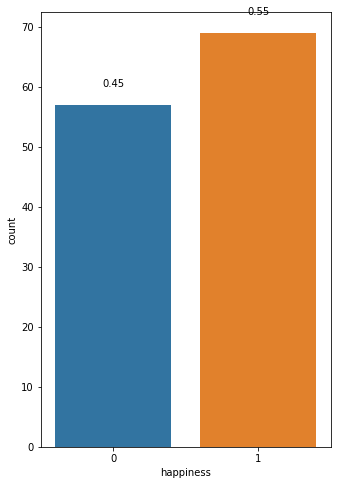

In [11]:
# customer feedback (happy/unhappy customer) distribution
plt.figure(figsize=(8, 8))
count_plot_('happiness', customer_data)
plt.show()

__In this data 45% of the customers are unhappy with the service.__

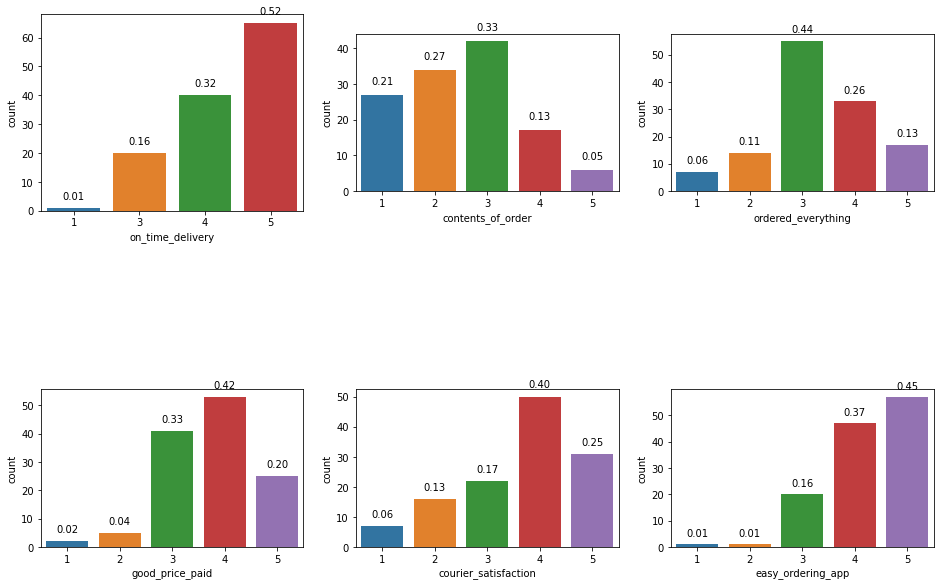

In [12]:
# Create a function for distribution plot
def count_plot(column_name, dataset, x=0, y=0):
    ax = sns.countplot(x=column_name, data= dataset, ax = axes[x, y])
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/float(len(dataset))),
            ha="center")
        ax.set_box_aspect(3/len(ax.patches))
        
# Distribution of other variables
fig, axes =plt.subplots(2,3, figsize=(16, 12))
count_plot('on_time_delivery', customer_data, x = 0, y= 0)
count_plot('contents_of_order', customer_data, x = 0, y= 1)
count_plot('ordered_everything', customer_data, x = 0, y= 2)
count_plot('good_price_paid', customer_data, x = 1, y= 0)
count_plot('courier_satisfaction', customer_data, x = 1, y= 1)
count_plot('easy_ordering_app', customer_data, x = 1, y= 2)

The feature X1 and X6 got highest number of 5 star ratings and the feature X2 got least number of 5 star ratings. Most of the customers are neutral about the feature X3 ( I ordered everything I wanted to order).

####  Correlation using Pearson Correlation

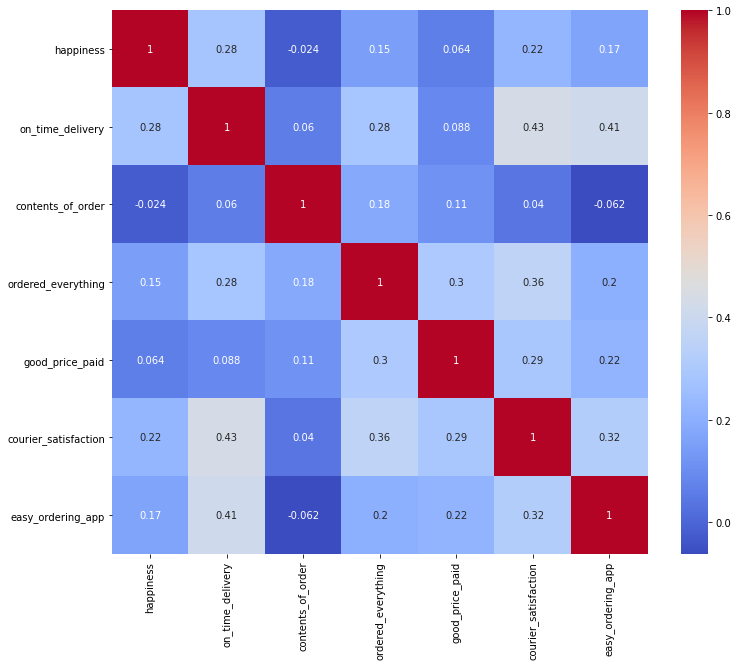

In [13]:
# Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = customer_data.corr()
sns.heatmap(cor, annot=True, cmap="coolwarm")
plt.show()

In [14]:
# Correlation with output variable
cor_target = cor["happiness"]
# Selecting highly positively correlated features
relevant_features = cor_target[cor_target>0.06]
relevant_features

happiness              1.00
on_time_delivery       0.28
ordered_everything     0.15
good_price_paid        0.06
courier_satisfaction   0.22
easy_ordering_app      0.17
Name: happiness, dtype: float64

- Positively correlated parameters are: on_time_delivery, ordered_everything, good_price_paid, courier_satisfaction and easy_ordering_app
- Negatively correlated parameter: contents_of_order

### Modeling with Lazy Predict

In [15]:
#set predictor variables and target variables
X = customer_data.drop(columns= ['happiness'])
y = customer_data.happiness

In [16]:
# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

# Show the results of the split
print("X Training set sample size:", (X_train.shape[0]))
print("X Testing set sample size:", (X_test.shape[0]))
print("y Training set sample size:", (y_train.shape[0]))
print("y Testing set sample size:", (y_test.shape[0]))

X Training set sample size: 113
X Testing set sample size: 13
y Training set sample size: 113
y Testing set sample size: 13


In [17]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
print(models)

100%|██████████| 29/29 [00:00<00:00, 35.88it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
ExtraTreeClassifier                0.77               0.76     0.76      0.77   
LabelPropagation                   0.69               0.70     0.70      0.69   
LabelSpreading                     0.69               0.70     0.70      0.69   
LGBMClassifier                     0.69               0.69     0.69      0.69   
SGDClassifier                      0.69               0.69     0.69      0.69   
QuadraticDiscriminantAnalysis      0.62               0.63     0.63      0.60   
RandomForestClassifier             0.62               0.62     0.62      0.62   
Perceptron                         0.62               0.62     0.62      0.62   
NuSVC                              0.62               0.62     0.62      0.62   
AdaBoostClassifier                 0.62               0.62     0.62      0.62   
ExtraTreesClassifier        

Lazy predict helps to builds different models and helps to understand which model works better without parameter tuning. Based on the lazy classifier output, I selected the top 3 classifiers for this classification problem based on the time taken and robustness of the model: LGBM (because it's a robust ensemble classifier), SGD classifier (robust classsifier), KNN (simple algorithm). I also compared Random forest, Logistic regression, XGBoost classifiers.

### Modeling: Logistic Regression, Random Forest, XGboost, LGBM, SGD and KNN with ScikitLearn

In [18]:
def evaluate(model, X_train, X_test, y_train, y_test):
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    y_test_pred_proba = model.predict_proba(X_test)[:,1]
    
    f1 = f1_score(y_test, y_test_pred)
    cm = confusion_matrix(y_test, y_test_pred)
    roc= roc_auc_score(y_test, y_test_pred_proba)

    print("TRAINIG RESULTS: \n===============================")
    print(f"ACCURACY SCORE:{accuracy_score(y_train, y_train_pred):.4f}")
    print(f"CONFUSION MATRIX:\n{confusion_matrix(y_train, y_train_pred)}")
    clf_report = pd.DataFrame(classification_report(y_train, y_train_pred, output_dict=True))
    print(f"CLASSIFICATION REPORT:\n{clf_report}")
    print()
    print()

    print("TESTING RESULTS: \n===============================")
    print(f"ACCURACY SCORE:{accuracy_score(y_test, y_test_pred):.4f}")
    print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_test_pred)}")
    
    print('F1-score: ' , round(f1,4))
    print("Best Score: " , round(model.best_score_,4))
    print("Test ROC AUC:", round(roc,4), '\n')
    print("Best Parameters: " , model.best_params_)
    clf_report = pd.DataFrame(classification_report(y_test, y_test_pred, output_dict=True))
    print(f"CLASSIFICATION REPORT:\n{clf_report}")
    
    
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr,tpr,label= 'f"{model}" ')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

###  Logistic Regression

TRAINIG RESULTS: 
ACCURACY SCORE:0.5929
CONFUSION MATRIX:
[[22 28]
 [18 45]]
CLASSIFICATION REPORT:
              0     1  accuracy  macro avg  weighted avg
precision  0.55  0.62      0.59       0.58          0.59
recall     0.44  0.71      0.59       0.58          0.59
f1-score   0.49  0.66      0.59       0.58          0.59
support   50.00 63.00      0.59     113.00        113.00


TESTING RESULTS: 
ACCURACY SCORE:0.3846
CONFUSION MATRIX:
[[1 6]
 [2 4]]
F1-score:  0.5
Best Score:  0.6293
Test ROC AUC: 0.6905 

Best Parameters:  {'penalty': 'l2', 'C': 2.0}
CLASSIFICATION REPORT:
             0    1  accuracy  macro avg  weighted avg
precision 0.33 0.40      0.38       0.37          0.36
recall    0.14 0.67      0.38       0.40          0.38
f1-score  0.20 0.50      0.38       0.35          0.34
support   7.00 6.00      0.38      13.00         13.00


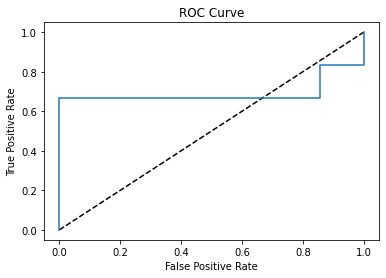

In [19]:
log_reg_params= {'penalty': ['l1','l2','elasticnet'], 'C':np.arange(0.5, 100.0, 0.5) }

log_reg = LogisticRegression()
log_rcv = RandomizedSearchCV(log_reg,log_reg_params,cv=10, n_jobs=-1, scoring = 'roc_auc',random_state = 42)
log_rcv.fit(X_train, y_train)
evaluate(log_rcv, X_train, X_test, y_train, y_test)

### Random Forest Classifier

TRAINIG RESULTS: 
ACCURACY SCORE:0.7876
CONFUSION MATRIX:
[[29 21]
 [ 3 60]]
CLASSIFICATION REPORT:
              0     1  accuracy  macro avg  weighted avg
precision  0.91  0.74      0.79       0.82          0.81
recall     0.58  0.95      0.79       0.77          0.79
f1-score   0.71  0.83      0.79       0.77          0.78
support   50.00 63.00      0.79     113.00        113.00


TESTING RESULTS: 
ACCURACY SCORE:0.5385
CONFUSION MATRIX:
[[3 4]
 [2 4]]
F1-score:  0.5714
Best Score:  0.654
Test ROC AUC: 0.7381 

Best Parameters:  {'n_estimators': 600, 'min_samples_split': 4, 'max_features': 'sqrt', 'max_depth': 4, 'criterion': 'entropy'}
CLASSIFICATION REPORT:
             0    1  accuracy  macro avg  weighted avg
precision 0.60 0.50      0.54       0.55          0.55
recall    0.43 0.67      0.54       0.55          0.54
f1-score  0.50 0.57      0.54       0.54          0.53
support   7.00 6.00      0.54      13.00         13.00


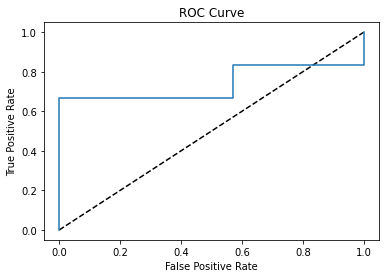

In [20]:
rf_params= { 'n_estimators': [500,600,800,1000,1500, 1800, 2000], 
             'max_features': ['auto', 'sqrt', 'log2'], 
             'max_depth' :  np.arange(4,20), 
             'criterion' :['gini', 'entropy'],
            'min_samples_split' : [2, 3, 4] }
rf = RandomForestClassifier()
rf_rcv = RandomizedSearchCV(rf,rf_params,cv=10, n_jobs=-1, scoring = 'roc_auc',random_state = 42)
rf_rcv.fit(X_train, y_train)
evaluate(rf_rcv, X_train, X_test, y_train, y_test)

#### Feature importance 

In [24]:
# Instantiate and fit the random forest model. 
rf = RandomForestClassifier().fit(X_train, y_train) 
# Explore feature importances
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
# Print sorted list of feature importances
feature_importances

,importance
contents_of_order,0.19
ordered_everything,0.19
courier_satisfaction,0.17
on_time_delivery,0.16
good_price_paid,0.16
easy_ordering_app,0.14


### XGBoost

[14:46:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


TRAINIG RESULTS: 
ACCURACY SCORE:0.8761
CONFUSION MATRIX:
[[38 12]
 [ 2 61]]
CLASSIFICATION REPORT:
              0     1  accuracy  macro avg  weighted avg
precision  0.95  0.84      0.88       0.89          0.89
recall     0.76  0.97      0.88       0.86          0.88
f1-score   0.84  0.90      0.88       0.87          0.87
support   50.00 63.00      0.88     113.00        113.00


TESTING RESULTS: 
ACCURACY SCORE:0.6154
CONFUSION MATRIX:
[[4 3]
 [2 4]]
F1-score:  0.6154
Best Score:  0.5893
Test ROC AUC: 0.6905 

Best Parameters:  {'subsample': 0.89, 'silent': 1, 'seed': 27, 'objective': 'binary:logistic', 'nthread': 10, 'n_estimators

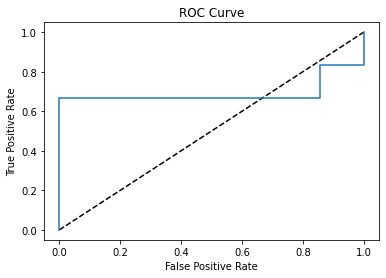

In [25]:
xgb_params= {'nthread':[10], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.05], #so called `eta` value
              'max_depth': [2],
              'min_child_weight':[1] ,
              'silent': [1],
              'subsample': [.89,.91,.895],
              'colsample_bytree':[.58,.585],
              'n_estimators': [1000],
             'seed': [27]}
             
xgb = XGBClassifier()
xgb_rcv = RandomizedSearchCV(xgb,xgb_params,cv=10, n_jobs=-1, scoring = 'roc_auc',random_state = 42)
xgb_rcv.fit(X_train, y_train)
evaluate(xgb_rcv, X_train, X_test, y_train, y_test)

### LGBM Classifier

TRAINIG RESULTS: 
ACCURACY SCORE:0.7522
CONFUSION MATRIX:
[[29 21]
 [ 7 56]]
CLASSIFICATION REPORT:
              0     1  accuracy  macro avg  weighted avg
precision  0.81  0.73      0.75       0.77          0.76
recall     0.58  0.89      0.75       0.73          0.75
f1-score   0.67  0.80      0.75       0.74          0.74
support   50.00 63.00      0.75     113.00        113.00


TESTING RESULTS: 
ACCURACY SCORE:0.6923
CONFUSION MATRIX:
[[5 2]
 [2 4]]
F1-score:  0.6667
Best Score:  0.5931
Test ROC AUC: 0.7262 

Best Parameters:  {'num_leaves': 300, 'min_child_weight': 0.2}
CLASSIFICATION REPORT:
             0    1  accuracy  macro avg  weighted avg
precision 0.71 0.67      0.69       0.69          0.69
recall    0.71 0.67      0.69       0.69          0.69
f1-score  0.71 0.67      0.69       0.69          0.69
support   7.00 6.00      0.69      13.00         13.00


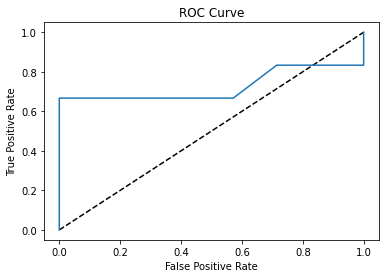

In [41]:
lgbm_params = {
          'num_leaves': np.arange(100,500,100),
          'min_child_weight': np.arange(0.01,1,0.01),
    }        
lgbm = LGBMClassifier()
lgbm_rcv = RandomizedSearchCV(lgbm,lgbm_params, cv=10, n_jobs=-1, scoring = 'roc_auc',random_state = 42)
lgbm_rcv.fit(X_train, y_train)
lgbm_rcv.fit(X_train, y_train)
evaluate(lgbm_rcv, X_train, X_test, y_train, y_test)

### SGD classifier

TRAINIG RESULTS: 
ACCURACY SCORE:0.6106
CONFUSION MATRIX:
[[24 26]
 [18 45]]
CLASSIFICATION REPORT:
              0     1  accuracy  macro avg  weighted avg
precision  0.57  0.63      0.61       0.60          0.61
recall     0.48  0.71      0.61       0.60          0.61
f1-score   0.52  0.67      0.61       0.60          0.61
support   50.00 63.00      0.61     113.00        113.00


TESTING RESULTS: 
ACCURACY SCORE:0.4615
CONFUSION MATRIX:
[[2 5]
 [2 4]]
F1-score:  0.5333
Best Score:  0.6379
Test ROC AUC: 0.7143 

Best Parameters:  {'penalty': 'l2', 'learning_rate': 'adaptive', 'eta0': 100, 'class_weight': {1: 0.5, 0: 0.5}, 'alpha': 0.1}
CLASSIFICATION REPORT:
             0    1  accuracy  macro avg  weighted avg
precision 0.50 0.44      0.46       0.47          0.47
recall    0.29 0.67      0.46       0.48          0.46
f1-score  0.36 0.53      0.46       0.45          0.44
support   7.00 6.00      0.46      13.00         13.00


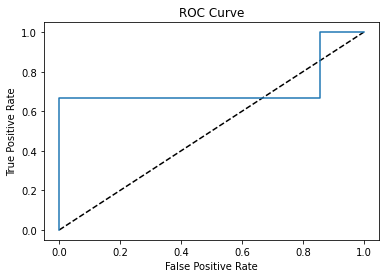

In [27]:
penalty = ['l1', 'l2', 'elasticnet'] 

alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000] 

learning_rate = ['constant', 'optimal', 'invscaling', 'adaptive'] 

class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}] 

eta0 = [1, 10, 100] 

sgd_params = dict(penalty=penalty, alpha=alpha, learning_rate=learning_rate, class_weight=class_weight, 
eta0=eta0) 

sgd = SGDClassifier(loss='log')
sgd_rcv = RandomizedSearchCV(sgd,sgd_params,cv=10, n_jobs=-1, scoring = 'roc_auc',random_state = 42)
sgd_rcv.fit(X_train, y_train)
evaluate(sgd_rcv, X_train, X_test, y_train, y_test)

In [129]:
sgd.get_params().keys()

dict_keys(['alpha', 'average', 'class_weight', 'early_stopping', 'epsilon', 'eta0', 'fit_intercept', 'l1_ratio', 'learning_rate', 'loss', 'max_iter', 'n_iter_no_change', 'n_jobs', 'penalty', 'power_t', 'random_state', 'shuffle', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

### KNN Classifier

In [29]:
knn=KNeighborsClassifier(n_neighbors=1)
knn.get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

TRAINIG RESULTS: 
ACCURACY SCORE:0.9469
CONFUSION MATRIX:
[[48  2]
 [ 4 59]]
CLASSIFICATION REPORT:
              0     1  accuracy  macro avg  weighted avg
precision  0.92  0.97      0.95       0.95          0.95
recall     0.96  0.94      0.95       0.95          0.95
f1-score   0.94  0.95      0.95       0.95          0.95
support   50.00 63.00      0.95     113.00        113.00


TESTING RESULTS: 
ACCURACY SCORE:0.6923
CONFUSION MATRIX:
[[4 3]
 [1 5]]
F1-score:  0.7143
Best Score:  0.6
Test ROC AUC: 0.7262 

Best Parameters:  {'weights': 'distance', 'n_neighbors': 10, 'n_jobs': -1, 'leaf_size': 5, 'algorithm': 'kd_tree'}
CLASSIFICATION REPORT:
             0    1  accuracy  macro avg  weighted avg
precision 0.80 0.62      0.69       0.71          0.72
recall    0.57 0.83      0.69       0.70          0.69
f1-score  0.67 0.71      0.69       0.69          0.69
support   7.00 6.00      0.69      13.00         13.00


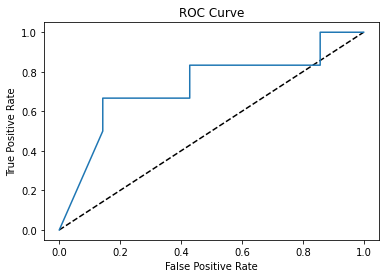

In [30]:
knn_params = {'n_neighbors':[5,6,7,8,9,10],
          'leaf_size':[1,2,3,5],
          'weights':['uniform', 'distance'],
          'algorithm':['auto', 'ball_tree','kd_tree','brute'],
          'n_jobs':[-1]}
knn_rcv = RandomizedSearchCV(knn,knn_params,cv=10, n_jobs=-1, scoring = 'roc_auc',random_state = 42)
knn_rcv.fit(X_train, y_train)
evaluate(knn_rcv, X_train, X_test, y_train, y_test)

### Recursive Feature Elimination



In [31]:
# feature extraction, Random Forest

rfe = RFE(rf, 5)
fit = rfe.fit(X_train, y_train)


In [32]:
#the best features according to RFE have a ranking of 1, so we'll create a second model with those features.

selected_features = pd.DataFrame({'Feature':list(X.columns),'Ranking':fit.ranking_})
selected_features.sort_values(by='Ranking')

,Feature,Ranking
0,on_time_delivery,1
1,contents_of_order,1
2,ordered_everything,1
3,good_price_paid,1
4,courier_satisfaction,1
5,easy_ordering_app,2


### Modeling after RFE

In [33]:
# drop the 'easy_ordering_app' feature from train and test set
X_train_rfe = X_train.drop(columns=['easy_ordering_app'])
X_test_rfe = X_test.drop(columns=['easy_ordering_app'])

__Random Forest__

TRAINIG RESULTS: 
ACCURACY SCORE:0.8142
CONFUSION MATRIX:
[[35 15]
 [ 6 57]]
CLASSIFICATION REPORT:
              0     1  accuracy  macro avg  weighted avg
precision  0.85  0.79      0.81       0.82          0.82
recall     0.70  0.90      0.81       0.80          0.81
f1-score   0.77  0.84      0.81       0.81          0.81
support   50.00 63.00      0.81     113.00        113.00


TESTING RESULTS: 
ACCURACY SCORE:0.6154
CONFUSION MATRIX:
[[4 3]
 [2 4]]
F1-score:  0.6154
Best Score:  0.6483
Test ROC AUC: 0.7381 

Best Parameters:  {'n_estimators': 1000, 'min_samples_split': 4, 'max_features': 'log2', 'max_depth': 5, 'criterion': 'entropy'}
CLASSIFICATION REPORT:
             0    1  accuracy  macro avg  weighted avg
precision 0.67 0.57      0.62       0.62          0.62
recall    0.57 0.67      0.62       0.62          0.62
f1-score  0.62 0.62      0.62       0.62          0.62
support   7.00 6.00      0.62      13.00         13.00


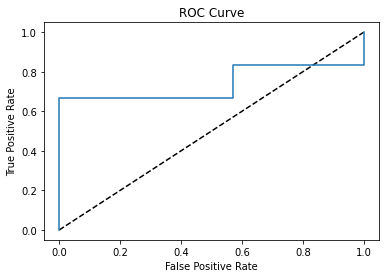

In [34]:
rf_rcv.fit(X_train_rfe, y_train)
evaluate(rf_rcv, X_train_rfe, X_test_rfe, y_train, y_test)

__Logistic Regression__

TRAINIG RESULTS: 
ACCURACY SCORE:0.5929
CONFUSION MATRIX:
[[22 28]
 [18 45]]
CLASSIFICATION REPORT:
              0     1  accuracy  macro avg  weighted avg
precision  0.55  0.62      0.59       0.58          0.59
recall     0.44  0.71      0.59       0.58          0.59
f1-score   0.49  0.66      0.59       0.58          0.59
support   50.00 63.00      0.59     113.00        113.00


TESTING RESULTS: 
ACCURACY SCORE:0.4615
CONFUSION MATRIX:
[[2 5]
 [2 4]]
F1-score:  0.5333
Best Score:  0.635
Test ROC AUC: 0.6905 

Best Parameters:  {'penalty': 'l2', 'C': 18.5}
CLASSIFICATION REPORT:
             0    1  accuracy  macro avg  weighted avg
precision 0.50 0.44      0.46       0.47          0.47
recall    0.29 0.67      0.46       0.48          0.46
f1-score  0.36 0.53      0.46       0.45          0.44
support   7.00 6.00      0.46      13.00         13.00


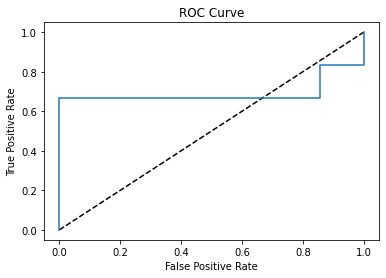

In [35]:
log_rcv.fit(X_train_rfe, y_train)
evaluate(log_rcv, X_train_rfe, X_test_rfe, y_train, y_test)

__XGBoost__

[14:56:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


TRAINIG RESULTS: 
ACCURACY SCORE:0.8230
CONFUSION MATRIX:
[[38 12]
 [ 8 55]]
CLASSIFICATION REPORT:
              0     1  accuracy  macro avg  weighted avg
precision  0.83  0.82      0.82       0.82          0.82
recall     0.76  0.87      0.82       0.82          0.82
f1-score   0.79  0.85      0.82       0.82          0.82
support   50.00 63.00      0.82     113.00        113.00


TESTING RESULTS: 
ACCURACY SCORE:0.6154
CONFUSION MATRIX:
[[4 3]
 [2 4]]
F1-score:  0.6154
Best Score:  0.6069
Test ROC AUC: 0.7143 

Best Parameters:  {'subsample': 0.895, 'silent': 1, 'seed': 27, 'objective': 'binary:logistic', 'nthread': 10, 'n_estimator

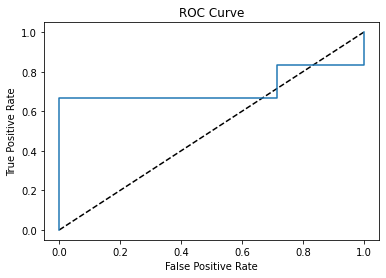

In [36]:
xgb_rcv.fit(X_train_rfe, y_train)
evaluate(xgb_rcv, X_train_rfe, X_test_rfe, y_train, y_test)

__LGBM Classifier__

TRAINIG RESULTS: 
ACCURACY SCORE:0.7080
CONFUSION MATRIX:
[[31 19]
 [14 49]]
CLASSIFICATION REPORT:
              0     1  accuracy  macro avg  weighted avg
precision  0.69  0.72      0.71       0.70          0.71
recall     0.62  0.78      0.71       0.70          0.71
f1-score   0.65  0.75      0.71       0.70          0.71
support   50.00 63.00      0.71     113.00        113.00


TESTING RESULTS: 
ACCURACY SCORE:0.8462
CONFUSION MATRIX:
[[6 1]
 [1 5]]
F1-score:  0.8333
Best Score:  0.5929
Test ROC AUC: 0.8333 

Best Parameters:  {'num_leaves': 300, 'min_child_weight': 0.2}
CLASSIFICATION REPORT:
             0    1  accuracy  macro avg  weighted avg
precision 0.86 0.83      0.85       0.85          0.85
recall    0.86 0.83      0.85       0.85          0.85
f1-score  0.86 0.83      0.85       0.85          0.85
support   7.00 6.00      0.85      13.00         13.00


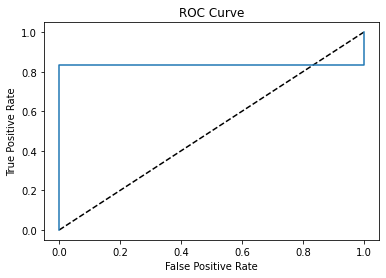

In [43]:
lgbm_rcv.fit(X_train_rfe, y_train)
evaluate(lgbm_rcv, X_train_rfe, X_test_rfe, y_train, y_test)

__SGD Classifier__

TRAINIG RESULTS: 
ACCURACY SCORE:0.5841
CONFUSION MATRIX:
[[23 27]
 [20 43]]
CLASSIFICATION REPORT:
              0     1  accuracy  macro avg  weighted avg
precision  0.53  0.61      0.58       0.57          0.58
recall     0.46  0.68      0.58       0.57          0.58
f1-score   0.49  0.65      0.58       0.57          0.58
support   50.00 63.00      0.58     113.00        113.00


TESTING RESULTS: 
ACCURACY SCORE:0.6154
CONFUSION MATRIX:
[[4 3]
 [2 4]]
F1-score:  0.6154
Best Score:  0.6445
Test ROC AUC: 0.7143 

Best Parameters:  {'penalty': 'l2', 'learning_rate': 'adaptive', 'eta0': 100, 'class_weight': {1: 0.5, 0: 0.5}, 'alpha': 0.1}
CLASSIFICATION REPORT:
             0    1  accuracy  macro avg  weighted avg
precision 0.67 0.57      0.62       0.62          0.62
recall    0.57 0.67      0.62       0.62          0.62
f1-score  0.62 0.62      0.62       0.62          0.62
support   7.00 6.00      0.62      13.00         13.00


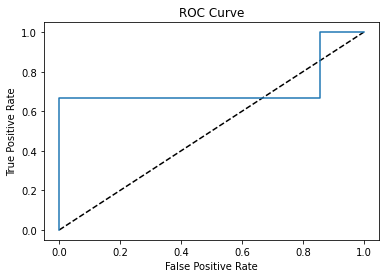

In [38]:
sgd_rcv.fit(X_train_rfe, y_train)
evaluate(sgd_rcv, X_train_rfe, X_test_rfe, y_train, y_test)

__KNN Classifier__

{'mean_fit_time': array([0.0051358 , 0.00443106, 0.00439341, 0.00436931, 0.00421028,
       0.00393689, 0.00508173, 0.00556633, 0.00540433, 0.00571091]), 'std_fit_time': array([0.00305742, 0.00134747, 0.00069131, 0.00077983, 0.00064047,
       0.00071639, 0.00102784, 0.00233381, 0.0006924 , 0.00083973]), 'mean_score_time': array([0.10915236, 0.1091305 , 0.10941789, 0.11026168, 0.10988157,
       0.10815394, 0.11097593, 0.11115205, 0.10999417, 0.11117873]), 'std_score_time': array([0.00298089, 0.00233358, 0.00224018, 0.00206682, 0.001269  ,
       0.00209634, 0.0020214 , 0.0035284 , 0.00209381, 0.00137296]), 'param_weights': masked_array(data=['distance', 'uniform', 'uniform', 'distance',
                   'distance', 'distance', 'distance', 'uniform',
                   'uniform', 'distance'],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_n_neighbors': masked_array(d

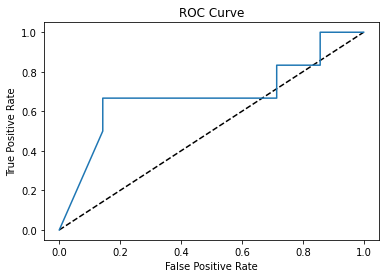

In [39]:
knn_rcv.fit(X_train_rfe, y_train)
print(knn_rcv.cv_results_)
evaluate(knn_rcv, X_train_rfe, X_test_rfe, y_train, y_test)

### Stacking Ensemble 

TRAINIG RESULTS: 
ACCURACY SCORE:0.8407
CONFUSION MATRIX:
[[32 18]
 [ 0 63]]
CLASSIFICATION REPORT:
              0     1  accuracy  macro avg  weighted avg
precision  1.00  0.78      0.84       0.89          0.88
recall     0.64  1.00      0.84       0.82          0.84
f1-score   0.78  0.88      0.84       0.83          0.83
support   50.00 63.00      0.84     113.00        113.00


TESTING RESULTS: 
ACCURACY SCORE:0.5385
CONFUSION MATRIX:
[[2 5]
 [1 5]]
F1-score:  0.625
Test ROC AUC: 0.7619 

CLASSIFICATION REPORT:
             0    1  accuracy  macro avg  weighted avg
precision 0.67 0.50      0.54       0.58          0.59
recall    0.29 0.83      0.54       0.56          0.54
f1-score  0.40 0.62      0.54       0.51          0.50
support   7.00 6.00      0.54      13.00         13.00


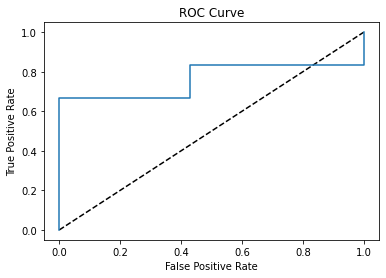

In [77]:
estimators = [('rf', rf_rcv),('lgbm', lgbm_rcv),('knn', knn_rcv)]
clf_stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

clf_stack.fit(X_train_rfe, y_train)
evaluate_stack(clf_stack, X_train_rfe, X_test_rfe, y_train, y_test)

In [45]:
def evaluate_stack(model, X_train, X_test, y_train, y_test):
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    y_test_pred_proba = model.predict_proba(X_test)[:,1]
    
    f1 = f1_score(y_test, y_test_pred)
    cm = confusion_matrix(y_test, y_test_pred)
    roc= roc_auc_score(y_test, y_test_pred_proba)

    print("TRAINIG RESULTS: \n===============================")
    print(f"ACCURACY SCORE:{accuracy_score(y_train, y_train_pred):.4f}")
    print(f"CONFUSION MATRIX:\n{confusion_matrix(y_train, y_train_pred)}")
    clf_report = pd.DataFrame(classification_report(y_train, y_train_pred, output_dict=True))
    print(f"CLASSIFICATION REPORT:\n{clf_report}")
    print()
    print()

    print("TESTING RESULTS: \n===============================")
    print(f"ACCURACY SCORE:{accuracy_score(y_test, y_test_pred):.4f}")
    print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_test_pred)}")
    
    print('F1-score: ' , round(f1,4))
    #print("Best Score: " , round(model.best_score_,4))
    print("Test ROC AUC:", round(roc,4), '\n')
    #print("Best Parameters: " , model.best_params_)
    clf_report = pd.DataFrame(classification_report(y_test, y_test_pred, output_dict=True))
    print(f"CLASSIFICATION REPORT:\n{clf_report}")
    
    
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr,tpr,label= 'f"{model}" ')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

### HyperOpt: Hyperparameter Tuning 

In [75]:
from hpsklearn import HyperoptEstimator
from hpsklearn import any_classifier
from hpsklearn import lightgbm
from hpsklearn import sgd
from hpsklearn import any_preprocessing
from hyperopt import tpe

In [76]:
# define search
model = HyperoptEstimator(classifier=any_classifier('cla'), preprocessing=any_preprocessing('pre'), algo=tpe.suggest, max_evals=50, trial_timeout=30)

# perform the search
model.fit(X_train, y_train)

# summarize performance
acc = model.score(X_test, y_test)
print("Accuracy: %.3f" % acc)

# summarize the best model
print(model.best_model())

100%|██████████| 50/50 [00:00<00:00,  5.90trial/s, best loss: 0.26086956521739135]
Accuracy: 0.692
{'learner': AdaBoostClassifier(learning_rate=2.375785434762205e-05, n_estimators=63,
                   random_state=2), 'preprocs': (MinMaxScaler(feature_range=(0.0, 1.0)),), 'ex_preprocs': ()}


### TPOT ML Learning

In [80]:
import tpot
from tpot import TPOTClassifier
# define search
model_tpot = TPOTClassifier(verbosity=3, 
                      scoring="balanced_accuracy", 
                      random_state=23, 
                      periodic_checkpoint_folder="tpot_mnst1.txt", 
                      n_jobs=-1, 
                      generations=10, 
                      population_size=100)
# perform the search
model_tpot.fit(X_train, y_train)
# export the best model
model_tpot.export()

32 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/1100 [00:00<?, ?pipeline/s]

_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required..
_pre_test decorator: _random_mutation_operator: num_test=0 Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty..
_pre_test decorator: _random_mutation_operator: num_test=0 '(slice(None, None, None), 0)' is an invalid key.
_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required..
_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required..
_pre_test decorator: _random_mutation_operator: num_test=0 Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty..
_pre_test decorator: _random_mutation_operator: num_test=0 Solver lbfgs supports only dual=False, got dual=True.
_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combina

_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required..
_pre_test decorator: _random_mutation_operator: num_test=1 Solver lbfgs supports only dual=False, got dual=True.
_pre_test decorator: _random_mutation_operator: num_test=0 '(slice(None, None, None), 0)' is an invalid key.
_pre_test decorator: _random_mutation_operator: num_test=0 Solver lbfgs supports only dual=False, got dual=True.
_pre_test decorator: _random_mutation_operator: num_test=1 Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty..
_pre_test decorator: _random_mutation_operator: num_test=0 l1 was provided as affinity. Ward can only work with euclidean distances..
_pre_test decorator: _random_mutation_operator: num_test=0 Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty..
_pre_test decorator: _random_mutation_operator: num_test=1 Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty..
_pre

_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 2 is required by FeatureAgglomeration..
_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required..
_pre_test decorator: _random_mutation_operator: num_test=0 Solver lbfgs supports only dual=False, got dual=True.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 6 - Current Pareto front scores:

-1	0.646923076923077	XGBClassifier(input_matrix, XGBClassifier__learning_rate=0.001, XGBClassifier__max_depth=6, XGBClassifier__min_child_weight=7, XGBClassifier__n_estimators=100, XGBClassifier__n_jobs=1, XGBClassifier__subsample=0.8, XGBClassifier__verbosity=0)

-2

_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required..
_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required..
_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required..
_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True.
_pre_test decorator: _random_mutation_operator: num_test=0 feature_names mismatch: ['on_time_delivery', 'contents_of_order', 'ordered_everything', 'good_price_paid', 'courier_satisfaction', 'easy_ordering_app'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5']
expected good_price_paid, contents_of_order, easy_ordering_app, ordered_everything, courier_s

_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False.
_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 51.
_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 70.
_pre_test decorator: _random_mutation_operator: num_test=0 Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty..
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous eval

'import numpy as np\nimport pandas as pd\nfrom sklearn.cluster import FeatureAgglomeration\nfrom sklearn.decomposition import PCA\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.neighbors import KNeighborsClassifier\nfrom sklearn.pipeline import make_pipeline\nfrom tpot.export_utils import set_param_recursive\n\n# NOTE: Make sure that the outcome column is labeled \'target\' in the data file\ntpot_data = pd.read_csv(\'PATH/TO/DATA/FILE\', sep=\'COLUMN_SEPARATOR\', dtype=np.float64)\nfeatures = tpot_data.drop(\'target\', axis=1)\ntraining_features, testing_features, training_target, testing_target = \\\n            train_test_split(features, tpot_data[\'target\'], random_state=23)\n\n# Average CV score on the training set was: 0.7080769230769232\nexported_pipeline = make_pipeline(\n    FeatureAgglomeration(affinity="cosine", linkage="complete"),\n    PCA(iterated_power=3, svd_solver="randomized"),\n    KNeighborsClassifier(n_neighbors=8, p=1, weights="distance")\n)\n

### Conclusion

In this problem, I used supervised machine learning classification algorithms to predict if a customer is happy or not based on their feedback. 
From the EDA, the data distribution shows 45% of customers are unhappy with the service. Most of the customers highly rated the on-time delivery service and app's easy ordering functionality.
The customers were unhappy and rated low on the contents of the order delivered. 

I build classification models to predict customer happiness. First, to have an idea about which model works better before parameter tuning, I used the LazyPredict library to build different models. Based on the LazyClassifier output, I selected 3 classifiers for this classification problem: LGBM, KNN, and SGD classifiers. I also modeling with Random Forest, Logistic Regression, and XGBoost classifiers.
To further improve the classifier performance I did feature selection using Recursive Feature Selection (RFE). Based on the RFE feature ranking, I removed the easy_ordering_app feature from the training data and retrain the model.

Based on the model performance, the three best classifiers are LGBM (accuracy score:0.84), KNN (accuracy score: 0.69), and Random Forest (accuracy score: 0.61). The model performance can also be improved by collecting more data in the future.
I also performed Stacking Ensemble on the above three best classifiers, however, there was not much improvement in the model performance. I also implemented HyperOpt parameter tuning and TPOT classifier in this dataset.  

The variables with the highest importance values were the X2 (contents of my order was as I expected) and X1 (my order was delivered on time). So the customers were mostly unhappy with the contents of the order. The contents of the order are either being damaged or changed which can be improved by systematic and careful handling of the order.
